In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [ ]:
torch.manual_seed(20)

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [ ]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [ ]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.to('cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))


for step in range(total_steps):
    model_output, coords = img_siren(model_input.to('cuda'))    
    loss = ((model_output - ground_truth.to('cuda'))**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.327216
Step 10, Total loss 0.044806
Step 20, Total loss 0.022206
Step 30, Total loss 0.016597
Step 40, Total loss 0.013834
Step 50, Total loss 0.012144
Step 60, Total loss 0.011013
Step 70, Total loss 0.010150
Step 80, Total loss 0.009429
Step 90, Total loss 0.008781
Step 100, Total loss 0.008166
Step 110, Total loss 0.007574
Step 120, Total loss 0.007015
Step 130, Total loss 0.006499
Step 140, Total loss 0.006016
Step 150, Total loss 0.005559
Step 160, Total loss 0.005132
Step 170, Total loss 0.004741
Step 180, Total loss 0.004377
Step 190, Total loss 0.004037
Step 200, Total loss 0.003731
Step 210, Total loss 0.003460
Step 220, Total loss 0.003220
Step 230, Total loss 0.003005
Step 240, Total loss 0.002813
Step 250, Total loss 0.003105
Step 260, Total loss 0.002546
Step 270, Total loss 0.002379
Step 280, Total loss 0.002231
Step 290, Total loss 0.002112
Step 300, Total loss 0.002007
Step 310, Total loss 0.001912
Step 320, Total loss 0.001825
Step 330, Total loss 

In [ ]:
model_input.shape

torch.Size([1, 65536, 2])

In [ ]:
!pip install 'ray[tune]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 44.4 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
from ray import tune

In [ ]:
import ray

In [ ]:
ray.init(num_gpus=1, ignore_reinit_error=True) 

2023-05-19 09:37:22,286	INFO worker.py:1625 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.4.0


In [ ]:
def training_function(config):
  omega = config["omega"]
  torch.manual_seed(20)
  cameraman = ImageFitting(256)
  dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

  img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True, first_omega_0 = omega, hidden_omega_0 = omega)
  img_siren.cuda()
  total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
  steps_til_summary = 10

  optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

  model_input, ground_truth = next(iter(dataloader))


  for step in range(total_steps):
      model_output, coords = img_siren(model_input.cuda())    
      loss = ((model_output - ground_truth.cuda())**2).mean()

      #if not step % steps_til_summary:
          #print("Step %d, Total loss %0.6f" % (step, loss))
      tune.report(loss = loss)
      optim.zero_grad()
      loss.backward()
      optim.step()

In [ ]:
analysis = tune.run(training_function, config={"omega":tune.grid_search(np.arange(10,101,10))}, resources_per_trial={"gpu": 1})

(training_function pid=11136) /usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
(training_function pid=11136)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
training_function_4d7d2_00000,2023-05-19_10-10-23,True,0_omega=ref_ph_f59c514f,bcf4e758743d,500,0.0102526,172.28.0.12,11136,24.1463,0.0410993,24.1463,1684491023,500,4d7d2_00000
training_function_4d7d2_00001,2023-05-19_10-10-48,True,1_omega=ref_ph_334c2cd0,bcf4e758743d,500,0.00171427,172.28.0.12,11343,21.0815,0.0395186,21.0815,1684491048,500,4d7d2_00001
training_function_4d7d2_00002,2023-05-19_10-11-13,True,2_omega=ref_ph_b4d2c831,bcf4e758743d,500,0.000983615,172.28.0.12,11496,20.9387,0.0409117,20.9387,1684491073,500,4d7d2_00002
training_function_4d7d2_00003,2023-05-19_10-11-40,True,3_omega=ref_ph_20f7e375,bcf4e758743d,500,0.000652173,172.28.0.12,11650,20.9943,0.0405412,20.9943,1684491100,500,4d7d2_00003
training_function_4d7d2_00004,2023-05-19_10-12-06,True,4_omega=ref_ph_216592ab,bcf4e758743d,500,0.000487445,172.28.0.12,11806,21.337,0.0401969,21.337,1684491126,500,4d7d2_00004
training_function_4d7d2_00005,2023-05-19_10-12-31,True,5_omega=ref_ph_f1f27a1c,bcf4e758743d,500,0.000319176,172.28.0.12,11963,21.0887,0.0402901,21.0887,1684491151,500,4d7d2_00005
training_function_4d7d2_00006,2023-05-19_10-12-56,True,6_omega=ref_ph_dfd47f69,bcf4e758743d,500,0.000249193,172.28.0.12,12117,20.9758,0.0394735,20.9758,1684491176,500,4d7d2_00006
training_function_4d7d2_00007,2023-05-19_10-13-23,True,7_omega=ref_ph_2b3815d7,bcf4e758743d,500,0.000165681,172.28.0.12,12272,21.0181,0.0400758,21.0181,1684491203,500,4d7d2_00007
training_function_4d7d2_00008,2023-05-19_10-13-49,True,8_omega=ref_ph_0271b299,bcf4e758743d,500,0.00010177,172.28.0.12,12433,21.3926,0.0403044,21.3926,1684491229,500,4d7d2_00008
training_function_4d7d2_00009,2023-05-19_10-14-14,True,9_omega=ref_ph_e4bcb9d2,bcf4e758743d,500,7.44104e-05,172.28.0.12,12587,21.4469,0.0419893,21.4469,1684491254,500,4d7d2_00009


2023-05-19 10:10:24,020	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'omega': ('__ref_ph', 'f59c514f')}
(training_function pid=11343)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
(training_function pid=11343)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2023-05-19 10:10:48,983	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'omega': ('__ref_ph', '334c2cd0')}
(training_function pid=11496) /usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
(training_function pid=11496)   return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2023-05-19 10:11:13,767	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when log

In [ ]:
df = analysis.results_df
df

,loss,time_this_iter_s,done,training_iteration,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,experiment_tag,config/omega
trial_id,,,,,,,,,,,,,,
4d7d2_00000,"tensor(0.0103, device='cuda:0', requires_grad=...",0.041099,True,500,2023-05-19_10-10-23,1684491023,24.146346,11136,bcf4e758743d,172.28.0.12,24.146346,500,0_omega=ref_ph_f59c514f,10
4d7d2_00001,"tensor(0.0017, device='cuda:0', requires_grad=...",0.039519,True,500,2023-05-19_10-10-48,1684491048,21.081482,11343,bcf4e758743d,172.28.0.12,21.081482,500,1_omega=ref_ph_334c2cd0,20
4d7d2_00002,"tensor(0.0010, device='cuda:0', requires_grad=...",0.040912,True,500,2023-05-19_10-11-13,1684491073,20.938677,11496,bcf4e758743d,172.28.0.12,20.938677,500,2_omega=ref_ph_b4d2c831,30
4d7d2_00003,"tensor(0.0007, device='cuda:0', requires_grad=...",0.040541,True,500,2023-05-19_10-11-40,1684491100,20.994282,11650,bcf4e758743d,172.28.0.12,20.994282,500,3_omega=ref_ph_20f7e375,40
4d7d2_00004,"tensor(0.0005, device='cuda:0', requires_grad=...",0.040197,True,500,2023-05-19_10-12-06,1684491126,21.337044,11806,bcf4e758743d,172.28.0.12,21.337044,500,4_omega=ref_ph_216592ab,50
4d7d2_00005,"tensor(0.0003, device='cuda:0', requires_grad=...",0.040290,True,500,2023-05-19_10-12-31,1684491151,21.088707,11963,bcf4e758743d,172.28.0.12,21.088707,500,5_omega=ref_ph_f1f27a1c,60
4d7d2_00006,"tensor(0.0002, device='cuda:0', requires_grad=...",0.039474,True,500,2023-05-19_10-12-56,1684491176,20.975762,12117,bcf4e758743d,172.28.0.12,20.975762,500,6_omega=ref_ph_dfd47f69,70
4d7d2_00007,"tensor(0.0002, device='cuda:0', requires_grad=...",0.040076,True,500,2023-05-19_10-13-23,1684491203,21.018053,12272,bcf4e758743d,172.28.0.12,21.018053,500,7_omega=ref_ph_2b3815d7,80
4d7d2_00008,"tensor(0.0001, device='cuda:0', requires_grad=...",0.040304,True,500,2023-05-19_10-13-49,1684491229,21.392607,12433,bcf4e758743d,172.28.0.12,21.392607,500,8_omega=ref_ph_0271b299,90


In [ ]:
torch.cuda.is_available()

True

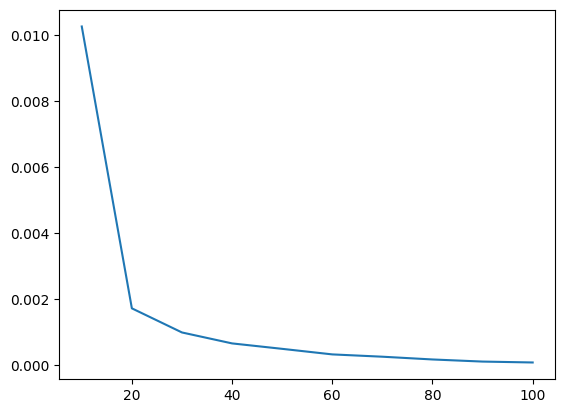

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['config/omega'], df['loss'])

In [ ]:
df[['config/omega', 'loss']]

,config/omega,loss
trial_id,,
4d7d2_00000,10,"tensor(0.0103, device='cuda:0', requires_grad=..."
4d7d2_00001,20,"tensor(0.0017, device='cuda:0', requires_grad=..."
4d7d2_00002,30,"tensor(0.0010, device='cuda:0', requires_grad=..."
4d7d2_00003,40,"tensor(0.0007, device='cuda:0', requires_grad=..."
4d7d2_00004,50,"tensor(0.0005, device='cuda:0', requires_grad=..."
4d7d2_00005,60,"tensor(0.0003, device='cuda:0', requires_grad=..."
4d7d2_00006,70,"tensor(0.0002, device='cuda:0', requires_grad=..."
4d7d2_00007,80,"tensor(0.0002, device='cuda:0', requires_grad=..."
4d7d2_00008,90,"tensor(0.0001, device='cuda:0', requires_grad=..."


In [ ]:
np.arange(10,100,10)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])